In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
sys.path.insert(1, r'C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\tree_models\tree_model_functions.py')
import tree_model_functions

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Selecting the DataSource
dataSource = r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\immonet_data\cleaned_data_without_NaN.csv"

# Selecting columns to drop out of featureList and creating LabelList
featureDropList = ["_id", "observationDate", "state", "city", "AP_community", "base_rent"]
LabelList = ["base_rent"]

# Create DataFrame from DataSource
dataframe = pd.read_csv(dataSource)

# Create list of unique states
states = dataframe["state"].unique()

# Create list for model scores
state_prediction_score = []

# Create list for most important features
feature_importances = []

In [4]:
# Loop throug all states to train them seperately
for state in states:
    df = dataframe
    df = df[df["state"]  == state]

    # Create feature and label lists
    y = df[LabelList]
    X = df.drop(featureDropList, axis = 1)
    feature_list = list(X.columns)

    y = np.array(y)
    X = np.array(X)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    rf = RandomForestRegressor(n_estimators = 10, random_state=0)

    # Train the model on training data
    rf.fit(X_train, y_train)

    # Use the Regressors's predict method on the test data
    predictions = rf.predict(X_test)

    # Calculate the absolute errors
    errors = abs(predictions - y_test)

    # Print out the mean absolute error (mae)
    #print('Average model error:', round(np.mean(errors), 2), 'euros.')
    
    # Calculate relative prediction errors
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

    # Count of predictions that are at least 10% accurate
    count_good_predictions = sum(1 for i in errors if i <= 10)

    # Proportion of good predictions for the Testset
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    #print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

    state_prediction_score.append([state, good_predictions])

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances_state = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = feature_importances + feature_importances_state

C:\Users\soube\AppData\Local\Temp\ipykernel_16976\268782935.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\268782935.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\268782935.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\268782935.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
C:\U

In [5]:
print(state_prediction_score)

[['Schleswig-Holstein', 75.22], ['Bremen', 55.62], ['Hessen', 67.07], ['Hamburg', 75.24], ['Nordrhein-Westfalen', 66.96], ['Baden-Württemberg', 56.86], ['Bayern', 64.55], ['Thüringen', 60.42], ['Mecklenburg-Vorpommern', 64.9], ['Sachsen', 74.13], ['Brandenburg', 59.25], ['Berlin', 71.18], ['Saarland', 56.2], ['Sachsen-Anhalt', 65.43], ['Niedersachsen', 66.4], ['Rheinland-Pfalz', 55.52]]


In [6]:
# Convert state_prediction_score list into DataFrame
state_prediction_df = pd.DataFrame(state_prediction_score, columns = ["state", "score"])
# Calculate the average score of the model
prediction_score = state_prediction_df["score"].mean()
print("Model score :", prediction_score, "%")

Model score : 64.684375 %


Performance auf Bayern-Daten: <br>
1. immonet_data\cleaned_data_without_NaN.csv = 64.55% (NaNs wurden gedroppt & mit Median befüllt) <br>
2. immonet_data\cleaned_data_without_NaN_and_without_drop.csv = 64.71 % (NaNs wurden mit Median befüllt) <br>
3. immonet_data\cleaned_data_conf_without_NaN = 56.21 % (Wie 1 aber nur Conf 9 Daten) <br>
4. immonet_data\cleaned_data_conf_without_NaN_and_without_drop = 57.95 % (Wie 2 aber nur Conf 9 Daten) <br>
5. immonet_data\raw_data_without_drop = 62.33 % (NaNs mit Median gefüllt und keine Outlier entfernt) <br>

### Get rid of unnnecessary Variables ###

In [7]:
feature_importances_df = pd.DataFrame(feature_importances, columns = ["Variable", "Importance"])
feature_importances_df["average_Importance"] = feature_importances_df["Importance"].groupby(feature_importances_df["Variable"]).transform("mean")
# Get the mean Importances for every Variable
mean_importances = feature_importances_df.groupby("Variable")["Importance"].mean()


cols = ["Variable", "average_Importance"]
mean_importances_list = feature_importances_df[cols].values.tolist()

# Sort and kick out all repetitive values
new_mean_importances_list = []
for i in mean_importances_list:
    if i not in new_mean_importances_list:
        new_mean_importances_list.append(i)
new_mean_importances_list = sorted(new_mean_importances_list, key = lambda x : x[1], reverse = True)

In [8]:
[print(new_mean_importances_list)]

[['livingSpace', 0.39125], ['deposit', 0.298125], ['averageRent_APC', 0.051875000000000004], ['constructionYear', 0.0475], ['distance_airport', 0.024375], ['energyConsumption', 0.0075], ['longitude', 0.006875], ['rentPerParking', 0.00625], ['distance_children', 0.00625], ['floorType', 0.0062499999999999995], ['latitude', 0.005625], ['distance_harbour', 0.005625], ['distance_tram_station', 0.005625], ['distance_beergarden', 0.005], ['distance_shelter', 0.005], ['distance_university', 0.004375], ['distance_nightclub', 0.004375], ['furnished', 0.00375], ['distance_clinic', 0.00375], ['condition', 0.003125], ['distance_museum', 0.003125], ['energyType', 0.0025], ['builtInKitchen', 0.0025], ['floorHeating', 0.0025], ['distance_recycling_center', 0.0025], ['distance_bar', 0.0025], ['distance_hotel', 0.0025], ['roomCount', 0.0018750000000000001], ['floor', 0.001875], ['heatingType', 0.001875], ['distance_charging_station', 0.001875], ['distance_restaurant', 0.001875], ['energyEfficiencyClass'

[None]

Text(0.5, 1.0, 'Variable Importances')

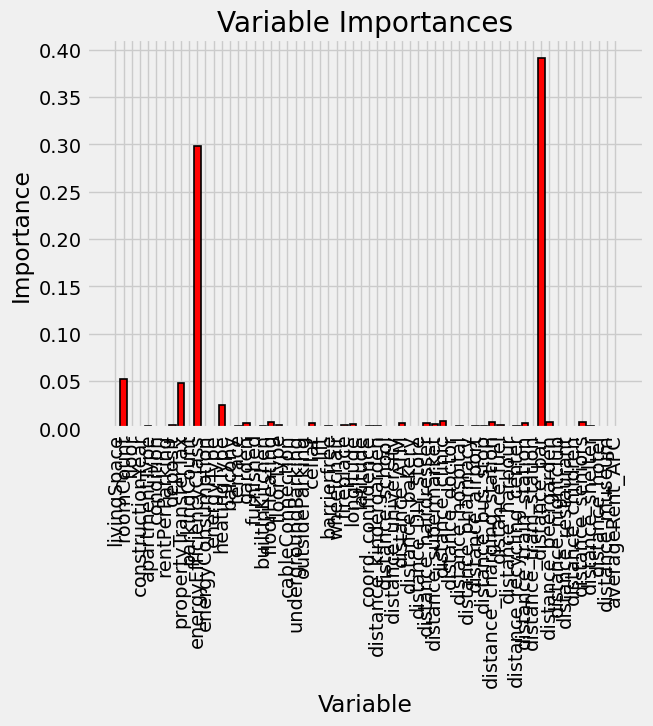

In [9]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(mean_importances)))

# Make a bar chart
plt.bar(x_values, mean_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5, 1.0, 'Cumulative Importances')

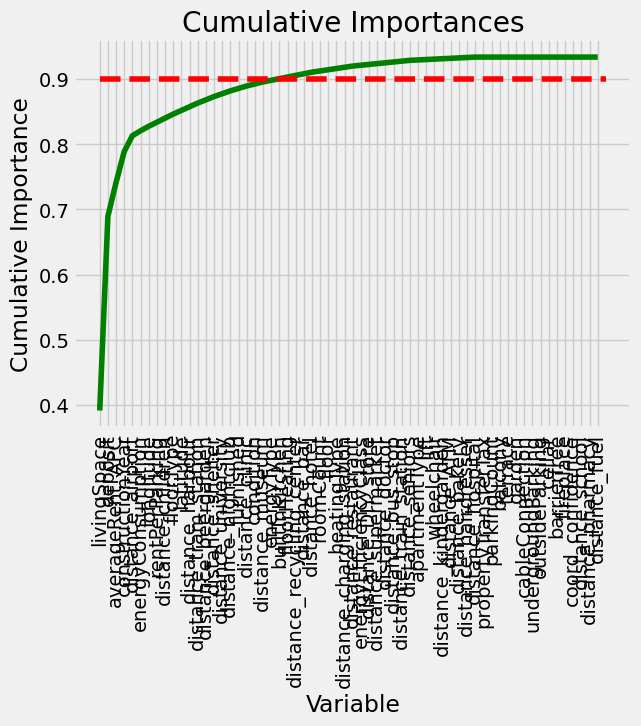

In [10]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in new_mean_importances_list]
sorted_features = [importance[0] for importance in new_mean_importances_list]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

In [11]:
# Find number of features for cumulative importance of 90%
# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.90)[0][0] + 1)

Number of features for 90% importance: 23


In [12]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:np.where(cumulative_importances > 0.90)[0][0] + 1]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_X_train = X_train[:, important_indices]
important_X_test = X_test[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

Important train features shape: (1304, 23)
Important test features shape: (326, 23)


In [13]:
# Train the expanded model on only the important features
rf.fit(important_X_train, y_train)

C:\Users\soube\AppData\Local\Temp\ipykernel_16976\1702952482.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(important_X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

In [14]:
# Make predictions on test data
predictions = rf.predict(important_X_test)

In [15]:
# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'euros.')
                    
# Calculate relative prediction errors
errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]

# Count of predictions that are at least 10% accurate
count_good_predictions = sum(1 for i in errors if i <= 10)

# Proportion of good predictions for the Testset
good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

Average model error: 279.66 euros.
Percentage of predictions with less than 10 % deviation:  59.51 %.


### Hyperparameter Tuning ###

In [16]:
# Selecting the DataSource
dataSource = r"C:\Users\soube\OneDrive\Desktop\Hammudi\Bachelorarbeit\Repository\AP-rent-determination\immonet_data\cleaned_data_without_NaN.csv"

# Selecting columns to drop out of featureList and creating LabelList
LabelList = ["base_rent"]

# Create DataFrame from DataSource
dataframe = pd.read_csv(dataSource)

# Create list for best random search params
best_random_search_params_list =  []

# Create list for best grid search params
best_grid_search_params_list =  []

In [17]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]
    count_good_predictions = sum(1 for i in errors if i <= 10)
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    return good_predictions
    print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

In [18]:
# Loop throug all states to train them seperately
for state in states:
    df = dataframe
    df = df[df["state"]  == state]

    # Create feature and label lists
    y = df[LabelList]
    X = df[important_feature_names]
    feature_list = list(X.columns)

    y = np.array(y)
    X = np.array(X)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

    # Instantiate model
    rf = RandomForestRegressor(n_estimators = 100, random_state=0)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start= 10, stop = 100, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = { 'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 10 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                n_iter = 100, scoring = 'neg_mean_absolute_error', 
                                cv = 3, verbose = 2, random_state = 0, n_jobs=-1)

    # Fit the random search model
    rf_random.fit(X_train, y_train)

    print("Best Params: ", rf_random.best_params_)

    # Evaluate the default model
    base_model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    base_model.fit(X_train, y_train)
    print("Base Model Performance for state: ", state)
    predictions = base_model.predict(X_test)
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]
    count_good_predictions = sum(1 for i in errors if i <= 10)
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

    # Evaluate the Best Random Search Model
    best_random = rf_random.best_estimator_
    print("Best Random Search Model Performance for state: ", state)
    predictions = best_random.predict(X_test)
    errors = [100 * (abs(predictions[i] - y_test[i])/ y_test[i]) for i in range(min(len(predictions), len(y_test)))]
    count_good_predictions = sum(1 for i in errors if i <= 10)
    good_predictions = round(np.mean(100 * (count_good_predictions / len(errors))), 2)
    print('Percentage of predictions with less than 10 % deviation: ', good_predictions, '%.')

    best_random_search_params_list = best_random_search_params_list + [state, best_random, good_predictions]

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Schleswig-Holstein
Percentage of predictions with less than 10 % deviation:  80.26 %.
Best Random Search Model Performance for state:  Schleswig-Holstein
Percentage of predictions with less than 10 % deviation:  79.61 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Best Params:  {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Base Model Performance for state:  Bremen
Percentage of predictions with less than 10 % deviation:  53.93 %.
Best Random Search Model Performance for state:  Bremen
Percentage of predictions with less than 10 % deviation:  56.18 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Hessen
Percentage of predictions with less than 10 % deviation:  66.35 %.
Best Random Search Model Performance for state:  Hessen
Percentage of predictions with less than 10 % deviation:  63.95 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Hamburg
Percentage of predictions with less than 10 % deviation:  79.09 %.
Best Random Search Model Performance for state:  Hamburg
Percentage of predictions with less than 10 % deviation:  77.64 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Nordrhein-Westfalen
Percentage of predictions with less than 10 % deviation:  66.79 %.
Best Random Search Model Performance for state:  Nordrhein-Westfalen
Percentage of predictions with less than 10 % deviation:  66.58 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Params:  {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Baden-Württemberg
Percentage of predictions with less than 10 % deviation:  54.08 %.
Best Random Search Model Performance for state:  Baden-Württemberg
Percentage of predictions with less than 10 % deviation:  55.67 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Bayern
Percentage of predictions with less than 10 % deviation:  60.54 %.
Best Random Search Model Performance for state:  Bayern
Percentage of predictions with less than 10 % deviation:  61.0 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Params:  {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Thüringen
Percentage of predictions with less than 10 % deviation:  56.51 %.
Best Random Search Model Performance for state:  Thüringen
Percentage of predictions with less than 10 % deviation:  54.4 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Best Params:  {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Base Model Performance for state:  Mecklenburg-Vorpommern
Percentage of predictions with less than 10 % deviation:  67.26 %.
Best Random Search Model Performance for state:  Mecklenburg-Vorpommern
Percentage of predictions with less than 10 % deviation:  65.49 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Params:  {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Sachsen
Percentage of predictions with less than 10 % deviation:  68.62 %.
Best Random Search Model Performance for state:  Sachsen
Percentage of predictions with less than 10 % deviation:  68.7 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Brandenburg
Percentage of predictions with less than 10 % deviation:  69.18 %.
Best Random Search Model Performance for state:  Brandenburg
Percentage of predictions with less than 10 % deviation:  67.12 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Best Params:  {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Base Model Performance for state:  Berlin
Percentage of predictions with less than 10 % deviation:  72.93 %.
Best Random Search Model Performance for state:  Berlin
Percentage of predictions with less than 10 % deviation:  75.11 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Best Params:  {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Base Model Performance for state:  Saarland
Percentage of predictions with less than 10 % deviation:  59.12 %.
Best Random Search Model Performance for state:  Saarland
Percentage of predictions with less than 10 % deviation:  64.23 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Params:  {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Sachsen-Anhalt
Percentage of predictions with less than 10 % deviation:  69.64 %.
Best Random Search Model Performance for state:  Sachsen-Anhalt
Percentage of predictions with less than 10 % deviation:  67.03 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Niedersachsen
Percentage of predictions with less than 10 % deviation:  65.68 %.
Best Random Search Model Performance for state:  Niedersachsen
Percentage of predictions with less than 10 % deviation:  66.4 %.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params:  {'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}


C:\Users\soube\AppData\Local\Temp\ipykernel_16976\3169994452.py:58: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train, y_train)


Base Model Performance for state:  Rheinland-Pfalz
Percentage of predictions with less than 10 % deviation:  61.66 %.
Best Random Search Model Performance for state:  Rheinland-Pfalz
Percentage of predictions with less than 10 % deviation:  59.51 %.


In [19]:
best_random_search_params_list

['Schleswig-Holstein',
 RandomForestRegressor(max_depth=40, max_features='auto', min_samples_leaf=2,
                       n_estimators=90),
 79.61,
 'Bremen',
 RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                       n_estimators=40),
 56.18,
 'Hessen',
 RandomForestRegressor(max_depth=50, max_features='auto', n_estimators=80),
 63.95,
 'Hamburg',
 RandomForestRegressor(max_depth=50, max_features='auto', n_estimators=80),
 77.64,
 'Nordrhein-Westfalen',
 RandomForestRegressor(max_depth=50, max_features='auto', n_estimators=80),
 66.58,
 'Baden-Württemberg',
 RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                       n_estimators=60),
 55.67,
 'Bayern',
 RandomForestRegressor(max_depth=50, max_features='auto', n_estimators=80),
 61.0,
 'Thüringen',
 RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                       n_estimators=60),
 54.4,
 'Mecklenburg-Vorpommern',
 RandomFores

In [20]:
# Grid Search für Schlesiwg-Holstein Daten

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [5, 8, 10],
    'n_estimators': [70, 100, 200, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best Params for state: ", state, grid_search.best_params_)

best_grid = grid_search.best_estimator_
evaluate_model(best_grid, X_test, y_test)

best_grid_search_params_list = best_grid_search_params_list + [state, best_grid, good_predictions]


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\Users\soube\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Params for state:  Rheinland-Pfalz {'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
